In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
from keras.utils import get_file
import os

data_url = 'https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/3364/31151/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1681387883&Signature=b%2Fa6hZN1sEaEs4Jhi9Fo1j8HvGjCcXvfw0nuioE7YmaGdCPDQKm4ldyLYh7zg7RtKrHVSABxHa2DJ0qHXbFVpEXszHuExNbkUnelCl7mbEh12g4AH9jMemvZMV61II%2FnxO28t6Y%2B4fK1RprqACBwo4I1SSCeooQ8Qg2qEgNS4OvbYlYnz%2BSJduBXx0UWO8lVL%2BPNJaBRjdSWOD9CQATrf6aelJqlit6Ll1oNGA6ccyMMdXHuw2sc6t8VRR0UySwtpnfVymJmpWi40HDkmoZ4pD86njmmSYcrfquE4pNJFN0M2TywokF2cZw1wxQ64eVWLm1YjlSdn5H2AA2RrNOlAA%3D%3D&response-content-disposition=attachment%3B+filename%3Dchallenges-in-representation-learning-facial-expression-recognition-challenge.zip'

zip_file = get_file(fname = 'challenges-in-representation-learning-facial-expression-recognition-challenge.zip', origin = data_url, extract = True)

base_dir, extension = os.path.splitext(zip_file)

train = pd.read_csv('/root/.keras/datasets/train.csv')

from sklearn.utils import resample

train_df = train[train['emotion'] == 1]
train_df = train_df

df_repeated = pd.concat([train_df]*10, ignore_index=True)

train = pd.concat([train, df_repeated], ignore_index=True, sort=False)

train['pixels'] = [np.fromstring(x, dtype = int, sep = ' ').reshape(-1, 48, 48, 1) for x in train['pixels']]
pixels = np.concatenate(train['pixels'])
labels = train.emotion.values

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(pixels, labels, test_size=0.2, random_state = 101)

X_train_new = np.repeat(X_train, repeats = 3, axis = 3)
X_test_new = np.repeat(X_test, repeats = 3, axis = 3)

from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(shear_range = 0.2, 
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   zoom_range = 0.2, 
                                   horizontal_flip = True, 
                                   rescale = 1/255)
test_datagen = ImageDataGenerator(rescale = 1/255)

train_iter = train_datagen.flow(X_train_new, y_train)

test_iter = test_datagen.flow(X_test_new, y_test)

train_iter.reset()

batchX, batchy = train_iter.next()

Xmin = batchX.min()
Xmax = batchX.max()

ymin = batchy.min()
ymax = batchy.max()

299063632/299063632 [==============================] - 13s 0us/step


In [ ]:
img_width, img_height = 48, 48
input_shape = (img_width, img_height, 1)

num_class = 7
batch_size = 32
epochs = 100

train_num = 28709
test_num = 7178

train_steps = train_num // batch_size
test_steps = test_num // batch_size

In [ ]:
base_model = tf.keras.applications.VGG16(
    input_shape = (48, 48, 3), 
    include_top = False, 
    weights = 'imagenet')

base_model.trainable = False

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
model2 = keras.Sequential(name = 'Final_Project_2')
model2.add(base_model)
model2.add(layers.Flatten())
model2.add(layers.Dense(512, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dropout(0.25))
model2.add(layers.Dense(7, activation='softmax'))

model2.summary()

Model: "Final_Project_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 7)             

In [ ]:
from keras.optimizers import Adam

opt = tf.keras.optimizers.Adam()

model2.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
y_train.shape

(26455, 7)

In [ ]:
history2 = model2.fit(X_train_new, y_train,
           epochs = 100,
           verbose=1,
           shuffle = True,
           validation_data = (X_test_new, y_test))

Epoch 1/100
827/827 [==============================] - 25s 19ms/step - loss: 2.7232 - accuracy: 0.2322 - val_loss: 1.8302 - val_accuracy: 0.2731
Epoch 2/100
827/827 [==============================] - 14s 17ms/step - loss: 1.7700 - accuracy: 0.3129 - val_loss: 1.6506 - val_accuracy: 0.3863
Epoch 3/100
827/827 [==============================] - 14s 17ms/step - loss: 1.6667 - accuracy: 0.3569 - val_loss: 1.5555 - val_accuracy: 0.4170
Epoch 4/100
827/827 [==============================] - 14s 17ms/step - loss: 1.5945 - accuracy: 0.3890 - val_loss: 1.5080 - val_accuracy: 0.4366
Epoch 5/100
827/827 [==============================] - 14s 17ms/step - loss: 1.5400 - accuracy: 0.4076 - val_loss: 1.4344 - val_accuracy: 0.4444
Epoch 6/100
827/827 [==============================] - 14s 17ms/step - loss: 1.4967 - accuracy: 0.4227 - val_loss: 1.4190 - val_accuracy: 0.4664
Epoch 7/100
827/827 [==============================] - 14s 17ms/step - loss: 1.4604 - accuracy: 0.4355 - val_loss: 1.3783 - val_ac

In [ ]:
score = model2.evaluate(test_iter)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

from sklearn.metrics import confusion_matrix

y_pred = model2.predict(X_train_new).argmax(axis = 1)
y_train = np.argmax(y_train, axis = 1)

confusion_matrix(y_train, y_pred)

207/207 [==============================] - 3s 13ms/step - loss: 2.3387 - accuracy: 0.1538
Test loss: 2.3387386798858643
Test accuracy: 0.1537647396326065
827/827 [==============================] - 10s 11ms/step


array([[2299,    0,  139,  294,  263,   10,  217],
       [   0, 3836,    0,    0,    0,    0,    0],
       [  70,    1, 2558,  138,  284,   32,  208],
       [  37,    0,   36, 5364,   75,    2,  244],
       [  77,    0,   75,  203, 3111,    0,  382],
       [   6,    5,  202,  113,    9, 2071,  135],
       [  37,    1,   32,  311,  121,    6, 3451]])

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.71      0.80      3222
           1       1.00      1.00      1.00      3836
           2       0.84      0.78      0.81      3291
           3       0.84      0.93      0.88      5758
           4       0.81      0.81      0.81      3848
           5       0.98      0.82      0.89      2541
           6       0.74      0.87      0.80      3959

    accuracy                           0.86     26455
   macro avg       0.87      0.85      0.86     26455
weighted avg       0.86      0.86      0.86     26455



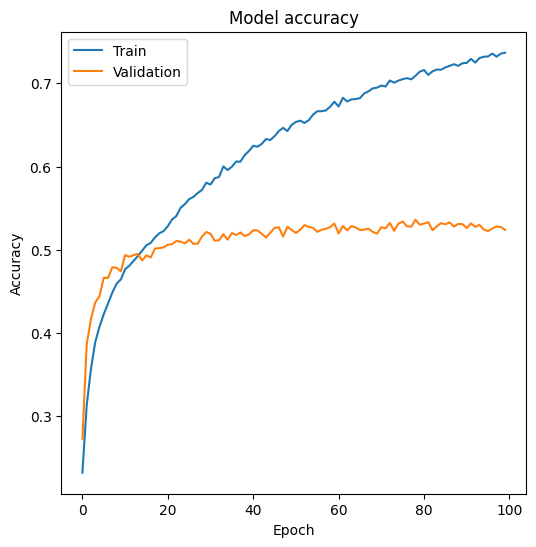

In [ ]:
plt.figure(figsize=(6, 6))
plt.title('Model accuracy')

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])

plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
tf.keras.models.save_model(model2, 'vgg_model.hdf5')